#### Notebook setup and imports

In addition to matplotlib and numpy, we will use the `dysts` library for some utilities, and the `degas` library for custom plotting.

    pip install dysts degas



In [36]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Turn on autoreload
%load_ext autoreload
%autoreload 2

from scripts.utils import smape

def smape_rolling(ts1, ts2):
    """Return the smape versus time for two time series."""
    n = min(ts1.shape[0], ts2.shape[0])
    all_smape = list()
    for i in range(n):
        smape_val = smape(ts1[:i], ts2[:i])
        all_smape.append(smape_val)
    return np.array(all_smape)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plot chronos benchmark results

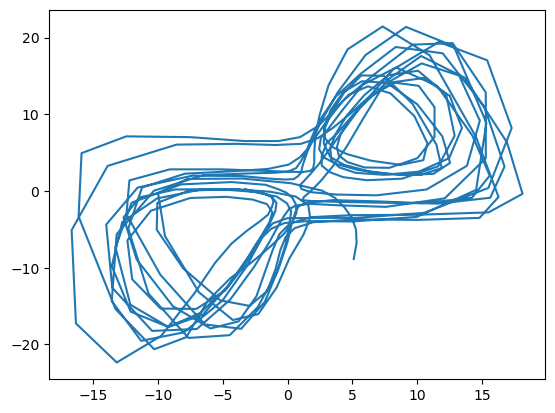

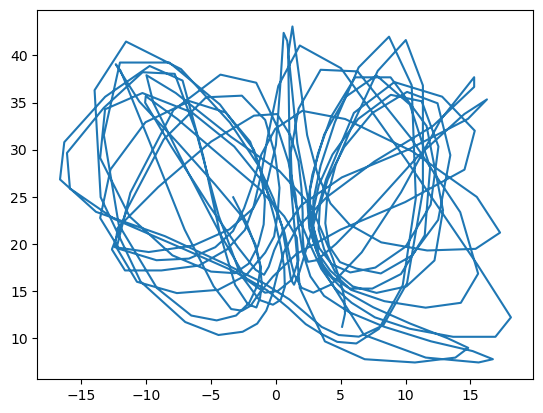

In [86]:
plt.figure()
plt.plot(forecast_multivariate[0], forecast_multivariate[1], label='Forecast')

plt.figure()
plt.plot(forecast_multivariate[0], forecast_multivariate[2], label='Forecast')

In [67]:
from scripts.models import ChronosModel

import dysts.flows

equation_name = "Lorenz"
model_size = "base"
# model_size = "tiny"

num_ic = 20
training_length = 1000
context_length = 512
forecast_length = 400 # Maximum for these models
# n_average = 20
n_average = 1
pts_per_period = 40
# pts_per_period = 10

eq = getattr(dysts.flows, equation_name)()
integrator_args = {
    # "pts_per_period": 40,
    "pts_per_period": 30,
    "atol": 1e-12,
    "rtol": 1e-12,
}

# traj0 = eq.make_trajectory(1200,
#                             timescale="Lyapunov",
#                             method="Radau", **integrator_args)
# eq.ic = traj0[-1]

traj0 = eq.make_trajectory(training_length + forecast_length,
                            # timescale="Lyapunov",
                            method="Radau", **integrator_args)
traj_test = np.array(traj0)[None, :]
traj_train = traj_test[:, :training_length] ## Training data for standard models                                     
traj_test_context = traj_test[:, training_length - context_length:training_length] ## Last context_length points for context models
ic_test = traj_test_context[:, -1] # Last seen point                                                                 
traj_test_forecast = traj_test[:, training_length:] ## Unseen data to be forecast


model = ChronosModel(model=model_size, 
                     context=context_length, 
                     n_samples=n_average, 
                     prediction_length=forecast_length, 
                     max_chunk=64)

# model = ChronosModel(model=model_size, 
#                      context=context_length, 
#                      n_samples=n_average, 
#                      prediction_length=forecast_length, 
#                      device=device)

for traj in traj_test_context:
    forecast_multivariate = np.array(model.predict(traj.T)).squeeze()


has gpu:  False
0 devices found.


/Users/william/micromamba/envs/chronos/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/william/micromamba/envs/chronos/lib/python3.12/site-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


In [82]:
def yy(x, *args):
    print(x, *args)

yy(9, 7, 7)

9 7 7


In [77]:
## One component at a time sequentially
forecast_multivariate = np.array([np.array(model.predict(item)) for item in traj.T]).squeeze()

/Users/william/micromamba/envs/chronos/lib/python3.12/site-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


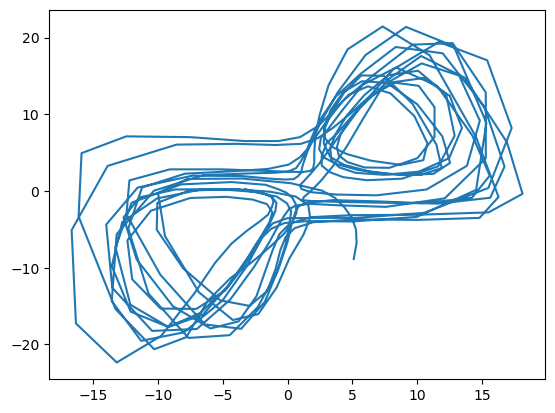

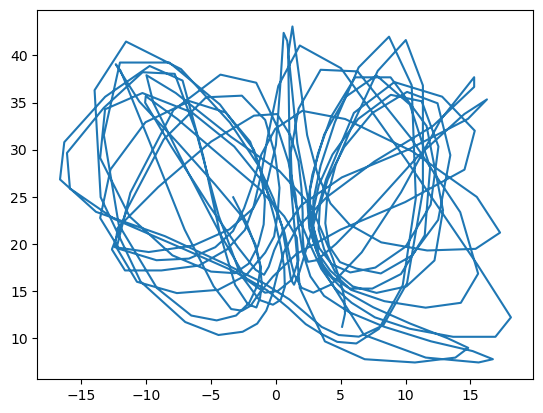

In [79]:

plt.figure()
plt.plot(forecast_multivariate[0], forecast_multivariate[1])

plt.figure()
plt.plot(forecast_multivariate[0], forecast_multivariate[2])

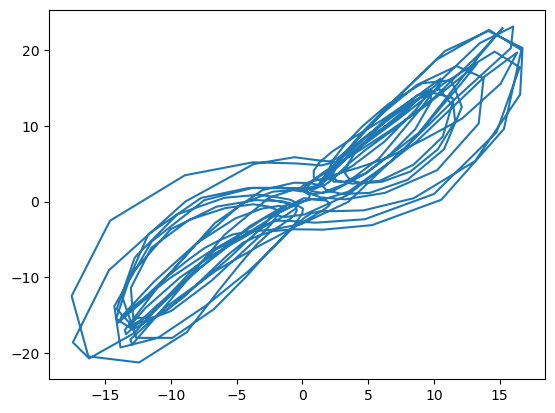

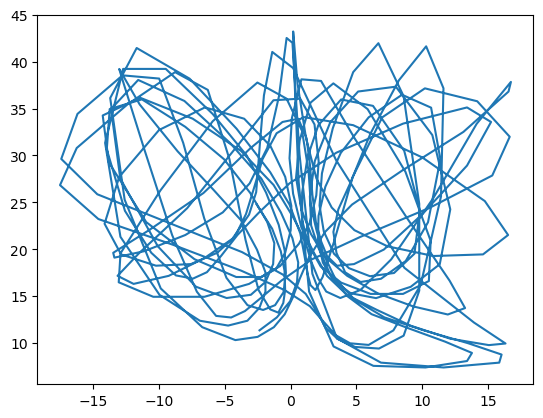

In [71]:

plt.figure()
plt.plot(forecast_multivariate[0], forecast_multivariate[1])

plt.figure()
plt.plot(forecast_multivariate[0], forecast_multivariate[2])

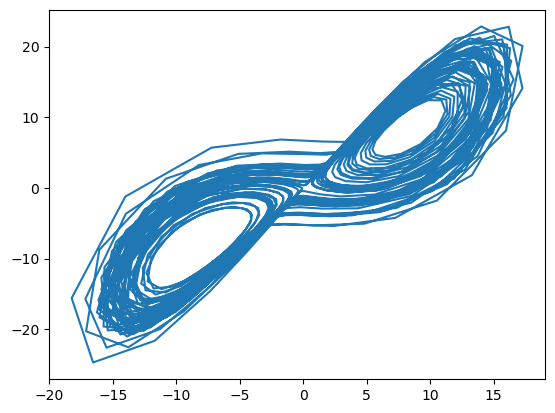

In [50]:
plt.plot(traj0[:,0], traj0[:,1])

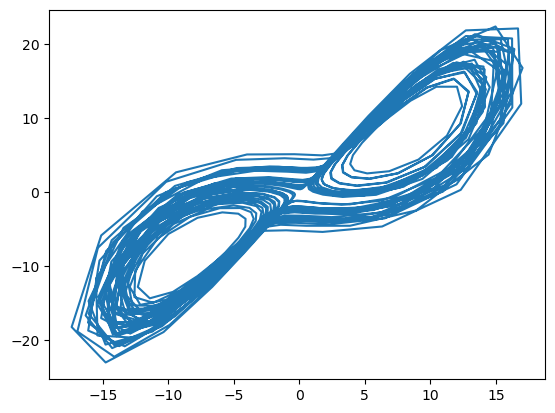

In [47]:
plt.plot(traj[:,0], traj[:,1])

# Properties across many models

#### First, let's load all of the zero-shot forecasting results. This will take a few minutes

In [600]:
from dysts.base import get_attractor_list
import os

model_sizes = ["tiny", "mini", "small", "base", "large"]
all_traces  = dict()
granularity = 30
BASE_DIR = "./zero-shot/chronos_benchmarks_context_512_granularity_30/"

equation_names = get_attractor_list()
for equation_name in equation_names:
# for equation_name in ["Lorenz", "Aizawa", "Arneodo", "ArnoldBeltrami", "AnishchenkoAstakhov", "Rossler"]:
    
    all_traces[equation_name] = dict()
    for model_size in model_sizes:
        try:
            
            all_traj_true = np.load(BASE_DIR + f"forecast_{equation_name}_granularity{granularity}_true_chronos.npy", allow_pickle=True)
            all_traj_forecasts = np.load(BASE_DIR + 
                f"forecast_{equation_name}_{model_size}_granularity{granularity}.npy", allow_pickle=True
            )
        except:
            print(f"Skipping {equation_name} {model_size}", flush=True)
            all_traces.pop(equation_name, None)
            continue

        # print(all_traj_true.shape, all_traj_forecasts.shape)
        
        # print(equation_name, flush=True)

        all_smape_rolling = list()
        ## Loop over all intial conditions, accounting for the fact that some predictions may not have been computed
        for traj_pred, traj_true in zip(all_traj_forecasts, all_traj_true[:len(all_traj_forecasts)]):
            all_smape = list()
            for i in range(traj_pred.shape[1]):
                smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
                if np.all(np.isnan(smape_val)):
                    pass
                else:
                    smape_val[np.isnan(smape_val)] = 0
                all_smape.append(smape_val)
            all_smape_rolling.append(all_smape)
        all_smape_rolling = np.array(all_smape_rolling)


        ## Across replicate initial conditions, take median
        ## Across different dimensions, take mean
        all_traces[equation_name][model_size] = np.nanmedian(np.nanmean(np.copy(all_smape_rolling), axis=1), axis=0)


/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_96657/3193293994.py:35: RuntimeWarning: All-NaN slice encountered
  smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)


Skipping IkedaDelay tiny
Skipping IkedaDelay mini
Skipping IkedaDelay small
Skipping IkedaDelay base
Skipping IkedaDelay large
Skipping MackeyGlass tiny
Skipping MackeyGlass mini
Skipping MackeyGlass small
Skipping MackeyGlass base
Skipping MackeyGlass large
Skipping PiecewiseCircuit tiny
Skipping PiecewiseCircuit mini
Skipping PiecewiseCircuit small
Skipping PiecewiseCircuit base
Skipping PiecewiseCircuit large
Skipping ScrollDelay tiny
Skipping ScrollDelay mini
Skipping ScrollDelay small
Skipping ScrollDelay base
Skipping ScrollDelay large
Skipping SprottDelay tiny
Skipping SprottDelay mini
Skipping SprottDelay small
Skipping SprottDelay base
Skipping SprottDelay large
Skipping StickSlipOscillator tiny
Skipping StickSlipOscillator mini
Skipping StickSlipOscillator small
Skipping StickSlipOscillator base
Skipping StickSlipOscillator large
Skipping Torus large
Skipping VossDelay tiny
Skipping VossDelay mini
Skipping VossDelay small
Skipping VossDelay base
Skipping VossDelay large


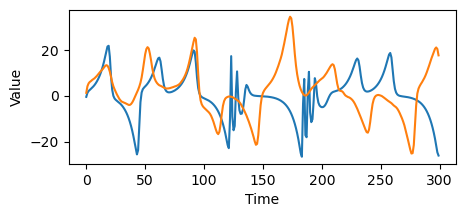

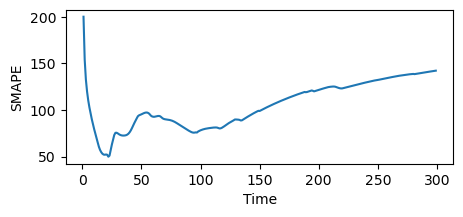

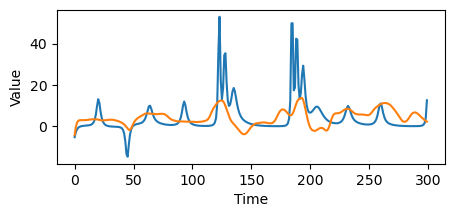

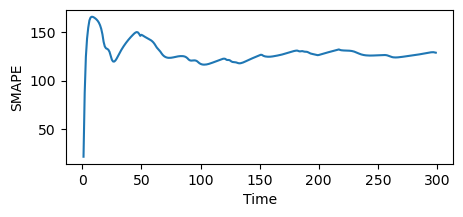

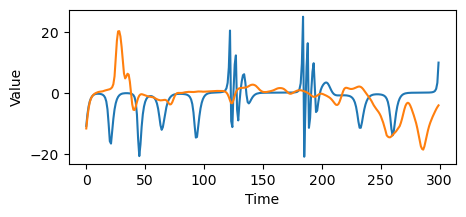

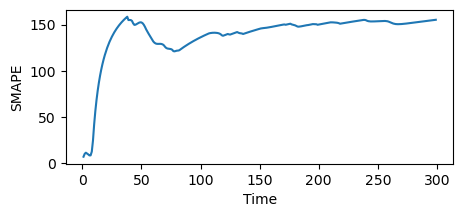

In [567]:
for i in range(3):
    traj_true, traj_pred = all_traj_true[0, :, i], all_traj_forecasts[0, :, i, 0]
    plt.figure(figsize=(5, 2))
    plt.plot(traj_true)
    plt.plot(traj_pred)
    plt.xlabel("Time")
    plt.ylabel("Value")

    plt.figure(figsize=(5, 2))
    plt.plot(smape_rolling(traj_true, traj_pred))
    plt.xlabel("Time")
    plt.ylabel("SMAPE")

#### Plot forecast results averaged across models

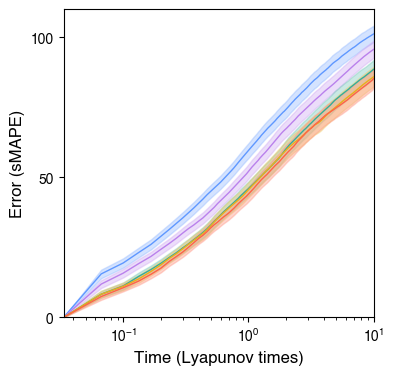

In [606]:

import degas as dg
smape_threshold = 30
all_all_vals, all_all_prediction_horizons = list(), list()
for model_size in all_traces["Aizawa"].keys():
    all_vals = list()
    all_horizons = list()
    for equation_name in all_traces.keys():

        ## Save traces
        vals = all_traces[equation_name][model_size]
        all_vals.append(vals)

        ## Save prediction horizon
        exceed_times = np.where(vals > smape_threshold)[0]
        if len(exceed_times) == 0:
            tind = len(vals)
        else:
            tind = exceed_times[0]
        all_horizons.append(tind)


    all_all_vals.append(np.array(all_vals))
    all_all_prediction_horizons.append(np.array(all_horizons))
all_all_vals = np.array(all_all_vals)
all_all_prediction_horizons = np.array(all_all_prediction_horizons)
xvals = np.arange(1, len(mv_vals) + 1) / granularity

all_colors = [dg.blue,  dg.lighter(dg.purple), dg.turquoise, dg.orange,   dg.red]

# import degas as dg

plt.figure(figsize=(4, 4))
for i, model_size in enumerate(model_sizes):
    n_sys = all_all_vals.shape[1]
    mv_vals = np.mean(all_all_vals, axis=1)[i]
    std_vals = np.std(all_all_vals, axis=1)[i]

    # plt.plot(mv_vals, label=model_size)
    plt.semilogx()
    dg.plot_err(mv_vals, std_vals / np.sqrt(n_sys) / 1.0, x=xvals, color=all_colors[i], label=model_size)

plt.xlabel("Time (Lyapunov times)", fontname="Helvetica", fontsize=12)
plt.ylabel("Error (sMAPE)", fontname="Helvetica", fontsize=12)
# plt.legend()
plt.xlim(np.min(xvals), np.max(xvals))
plt.ylim(0, 110)
plt.yticks([0, 50, 100])
# set font name of x-axis labels
plt.xticks(fontname="Helvetica")
plt.yticks(fontname="Helvetica")

# dg.better_savefig("./fig_resources/chronos_traces.png", dpi=300)

(array([0., 2., 4., 6.]),
 [Text(0, 0.0, '0'), Text(0, 2.0, '2'), Text(0, 4.0, '4'), Text(0, 6.0, '6')])

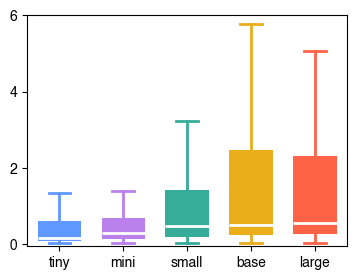

In [605]:
len(all_all_prediction_horizons)

plt.figure(figsize=(4.12, 3))

## Make a boxplot of the prediction horizons
# Use all_colors to color each box differently
# Boxes are very close together, so use a different color for each box
box = plt.boxplot(all_all_prediction_horizons.T / granularity, labels=model_sizes, patch_artist=True, showfliers=False, widths=0.34, positions=np.arange(len(model_sizes))/2)
plt.xlim(-0.25, 2.25)
plt.ylim(-0.05, 6)
for patch, color in zip(box['boxes'], all_colors):
    patch.set_facecolor(color)
    patch.set_linewidth(0)
    patch.set_edgecolor(color)

for median, color in zip(box['medians'], all_colors):
    median.set_color("w")
    median.set_linewidth(2)

for i, (cap, whisker) in enumerate(zip(box['caps'], box['whiskers'])):
    color = all_colors[i // 2]
    whisker.set_color(color)
    cap.set_color(color)
    whisker.set_linewidth(2)
    cap.set_linewidth(2)

plt.yticks([0.0, 2.0, 4.0, 6.0])
plt.xticks(fontname="Helvetica")
plt.yticks(fontname="Helvetica")

# plt.xlabel("Model Size")
# plt.ylabel("Prediction Horizon (Lyapunov times)")
# plt.title(f"Prediction Horizon for SMAPE > {smape_threshold}")


# dg.better_savefig("./fig_resources/legend.png", dpi=300)

### Correlation between forecast and invariant properties of different dynamical systems

In [608]:

## Load the invariant properties for each individual system
import dysts.flows as dfl
all_lyap = list()
all_corrdim = list()
all_kydim = list()
all_acc = list()
for equation_name in all_traces:
    

    # spec = np.array(getattr(dfl, equation_name)().lyapunov_spectrum_estimated)
    # try:
    #     all_lyap.append(np.sum(spec[spec > 0]))
    # except:
    #     all_lyap.append(getattr(dfl, equation_name)().maximum_lyapunov_estimated)
    all_lyap.append(getattr(dfl, equation_name)().maximum_lyapunov_estimated)
    all_corrdim.append(getattr(dfl, equation_name)().correlation_dimension)
    all_kydim.append(getattr(dfl, equation_name)().kaplan_yorke_dimension)
    

/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Text(0, 0.5, 'Correlation with Correlation Dimension')

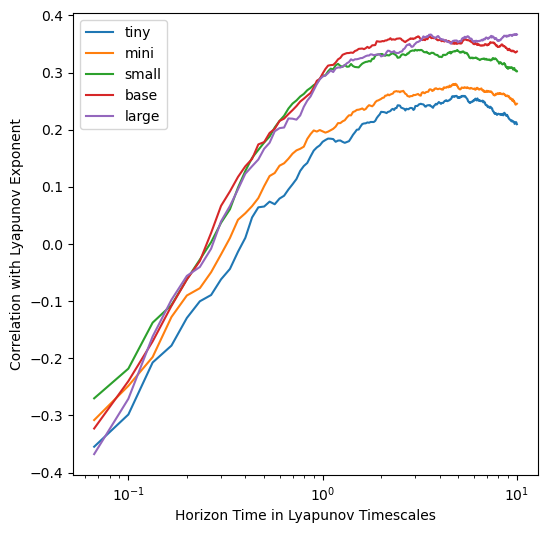

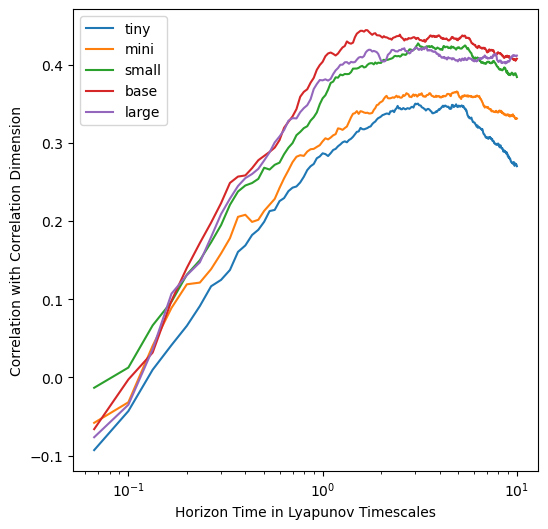

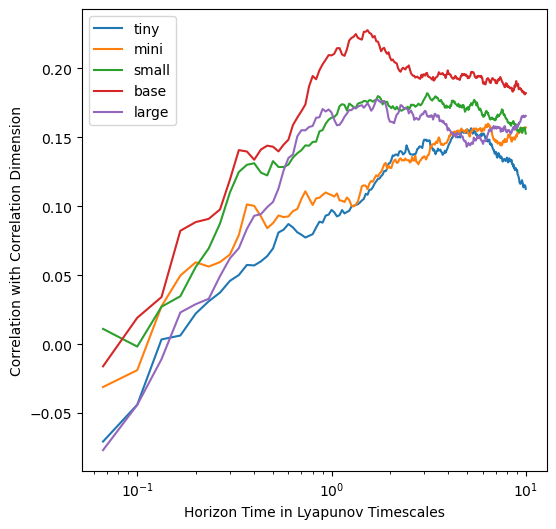

In [609]:
from scipy.stats import spearmanr

## Load the invariant properties for each individual system
plt.figure(figsize=(6, 6))
for model_size in model_sizes:
    all_corr_lyap = list()
    nt = len(all_traces[equation_name][model_size])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_size][i])
        corr = spearmanr(all_lyap, all_acc).correlation
        all_corr_lyap.append(corr)
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    plt.semilogx(xvals, all_corr_lyap, label=model_size)
plt.legend()
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with Lyapunov Exponent")

plt.figure(figsize=(6, 6))
for model_size in model_sizes:
    all_corr_corrdim = list()
    nt = len(all_traces[equation_name][model_size])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_size][i])
        corr = spearmanr(all_corrdim, all_acc).correlation
        all_corr_corrdim.append(corr)
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    plt.semilogx(xvals, all_corr_corrdim, label=model_size)
plt.legend()
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with Correlation Dimension")


plt.figure(figsize=(6, 6))
for model_size in model_sizes:
    all_corr_corrdim = list()
    nt = len(all_traces[equation_name][model_size])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_size][i])
        corr = spearmanr(all_kydim, all_acc).correlation
        all_corr_corrdim.append(corr)
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    xvals = np.arange(1, 1 + len(all_corr_lyap)) / granularity
    plt.semilogx(xvals, all_corr_corrdim, label=model_size)
plt.legend()
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with Correlation Dimension")



In [277]:
pp = f"./trained/forecast_{"Aizawa"}_{"Linear"}_granularity{pts_per_period}.npy"
all_traj_forecasts = np.load(
                pp, allow_pickle=True
            )

FileNotFoundError: [Errno 2] No such file or directory: './trained/forecast_Aizawa_Linear_granularity30.npy'

# Baseline models

In [610]:
import glob
from dysts.base import get_attractor_list

pts_per_period = 30
model_names = np.array(["Linear", "LSTM", "NBEATS", "NVAR", "TiDE", "Transformer"])
# model_names = ["NVAR", "LSTM", "TiDE"]
all_traces  = dict()

DIRNAME = "./trained/darts_benchmarks_granularity_30"

import glob
import os
import re
all_files = glob.glob(os.path.join(DIRNAME, f"forecast*.npy"))
equation_names = np.unique([re.search(r'forecast_(.*?)_', file_name).group(1) for file_name in all_files])
print(len(equation_names))

# equation_names = get_attractor_list()
# for equation_name in ["Lorenz", "Aizawa", "Arneodo", "ArnoldBeltrami", "AnishchenkoAstakhov", "Rossler"]:
for equation_name in equation_names:
    
    all_traces[equation_name] = dict()
    for model_name in model_names:
        try:
            # "/Users/william/program_repos/dysts_data/benchmark_results/trained/darts_benchmarks_granularity_30/forecast_Aizawa_granularity_30_true_dysts.npy"
            traj_test_forecast = np.load(f"./trained/darts_benchmarks_granularity_30/forecast_{equation_name}_granularity_{pts_per_period}_true_dysts.npy", allow_pickle=True)
            all_traj_forecasts = np.load(
                f"./trained/darts_benchmarks_granularity_30/forecast_{equation_name}_{model_name}_granularity{pts_per_period}.npy", allow_pickle=True
            )
        except Exception as e:
            print(e)
            print(f"Skipping {equation_name} {model_name}", flush=True)
            # all_traces.pop(equation_name, None)
            continue
        
        # print(equation_name, flush=True)

        all_smape_rolling = list()
        for traj_pred, traj_true in zip(all_traj_forecasts, traj_test_forecast):
            all_smape = list()
            for i in range(traj_pred.shape[1]):
                smape_val = smape_rolling(traj_pred[:, i], traj_true[:, i])
                if np.all(np.isnan(smape_val)):
                    pass
                else:
                    smape_val[np.isnan(smape_val)] = 0
                all_smape.append(smape_val)
            all_smape_rolling.append(all_smape)
        all_smape_rolling = np.array(all_smape_rolling)

        all_traces[equation_name][model_name] = np.nanmedian(np.nanmean(np.copy(all_smape_rolling), axis=1), axis=0)


/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_BlinkingVortex_Linear_granularity30.npy'
Skipping BlinkingVortex Linear
[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_BlinkingVortex_LSTM_granularity30.npy'
Skipping BlinkingVortex LSTM
[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_BlinkingVortex_NBEATS_granularity30.npy'
Skipping BlinkingVortex NBEATS
[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_BlinkingVortex_TiDE_granularity30.npy'
Skipping BlinkingVortex TiDE
[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_BlinkingVortex_Transformer_granularity30.npy'
Skipping BlinkingVortex Transformer
[Errno 2] No such file or directory: './trained/darts_benchmarks_granularity_30/forecast_Bouali_Linear_granularity30.npy'
Skipping Bouali Linear
[Errno 2] No such file or directory: './trained/

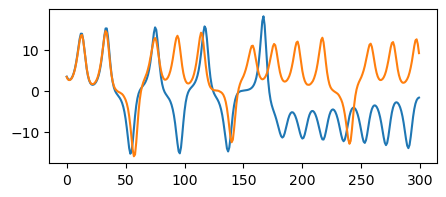

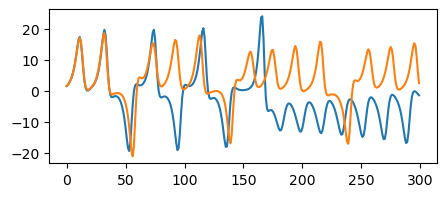

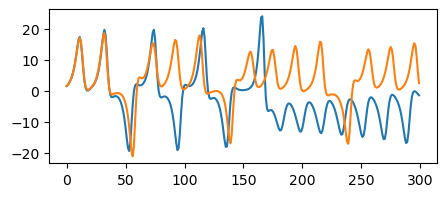

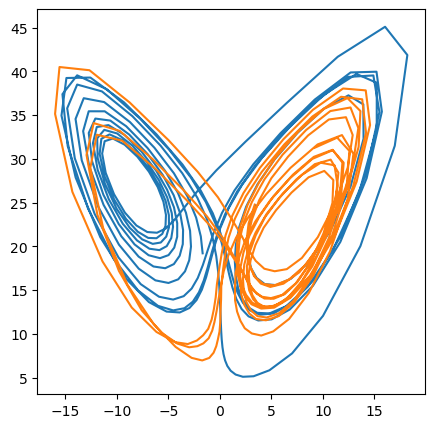

In [611]:
equation_name = "Lorenz"
model_name = "NBEATS"

traj_test_forecast = np.load(f"./trained/darts_benchmarks_granularity_30/forecast_{equation_name}_granularity_{pts_per_period}_true_dysts.npy", allow_pickle=True)
all_traj_forecasts = np.load(
    f"./trained/darts_benchmarks_granularity_30/forecast_{equation_name}_{model_name}_granularity{pts_per_period}.npy", allow_pickle=True
)

plt.figure(figsize=(5, 2))
plt.plot(traj_test_forecast[0, :, 0])
plt.plot(all_traj_forecasts[0, :, 0])

plt.figure(figsize=(5, 2))
plt.plot(traj_test_forecast[0, :, 1])
plt.plot(all_traj_forecasts[0, :, 1])

plt.figure(figsize=(5, 2))
plt.plot(traj_test_forecast[0, :, 1])
plt.plot(all_traj_forecasts[0, :, 1])


plt.figure(figsize=(5, 5))
plt.plot(traj_test_forecast[0, :, 0], traj_test_forecast[0, :, 2])
plt.plot(all_traj_forecasts[0, :, 0], all_traj_forecasts[0, :, 2])

In [673]:
def lighter(clr, f=1/3):
    """
    Lighten an RGB color value. Based on Mathematica's Lighter[] function for RGB colors
    
    Args:
        clr (3-tuple): An RGB color
        f (float): The fraction by which to brighten the color
    
    Returns:
        new_clr (3-tuple): The new, lightened color
    """
    gaps = [f*(1 - val) for val in clr]
    new_clr = [val + gap for gap, val in zip(gaps, clr)]
    return new_clr

def plot_err2(
    y, 
    errs, 
    x=[], 
    color=(0,0,0), 
    loglog=False,
    lightness=0.33/.5,
    ax=None,
    fill_kwargs={},
    **plot_kwargs):
    """
    Plot a curve with error bars

    Args:
        y (array): A list of values to plot
        errs (array): A list of errors, or a pair of lists of upper and lower errors 
        x (array): A list of x positions
        color (3-tuple): The color of the plot lines and error bars
        loglog (bool): Whether to plot the x and y axes in log scale
        lightness (float): The visual lightness of the error bars
        fill_kwargs (dict): keyword arguments passed to the region filling plot
        plot_kwargs: passed to the line plot

    Returns:
        ax (matplotlib.axes.Axes): The axes on which the plot was drawn

    Example:
        x = np.linspace(0, 10, 100)
        y = np.sin(x)
        errs = np.random.random(100) * .1
        plot_err(y, errs, x=x, color=(0,0,1))

    """
    if ax is None:
        ax = plt.gca()
    if len(x) < 1:
        x = np.arange(len(y))
    
    if len(errs.shape) > 1:
        if errs.shape[1] == 2:
            err_lo, err_hi = errs[:, 0], errs[:, 1]
    else:
        err_lo = errs
        err_hi = errs
        
    trace_lo, trace_hi = y - err_lo, y + err_hi

    
    ## Set default colors and other plot properties
    all_fill_kwargs = dict(
        color=lighter(color, lightness),
    )
    
    all_plot_kwargs = dict(
        color=color,
    )
    
    all_plot_kwargs.update(plot_kwargs) # update to user-specified plot_kwargs
    lineplot = ax.plot(x, y, **all_plot_kwargs)
    # print(dir(lineplot))
    z = lineplot[0].get_zorder()

    all_fill_kwargs["zorder"] = z - 1
    all_fill_kwargs.update(fill_kwargs) # update to user-specified fill_kwargs
    fillplot = ax.fill_between(x, trace_lo, trace_hi, **all_fill_kwargs)
    print(fillplot.get_zorder())
    # ax.plot(x, y, **all_plot_kwargs)

    if loglog:
        ax.yscale('log', nonposy='clip')
        ax.xscale('log', nonposy='clip')
    
    return ax

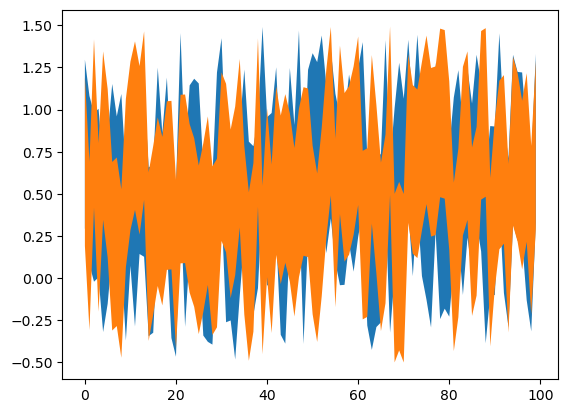

In [650]:
xx = np.random.random(100)
plt.fill_between(np.arange(len(xx)), xx - 0.5, xx + 0.5, zorder=0)
xx = np.random.random(100)
plt.fill_between(np.arange(len(xx)), xx - 0.5, xx + 0.5, zorder=2)

1


<Axes: >

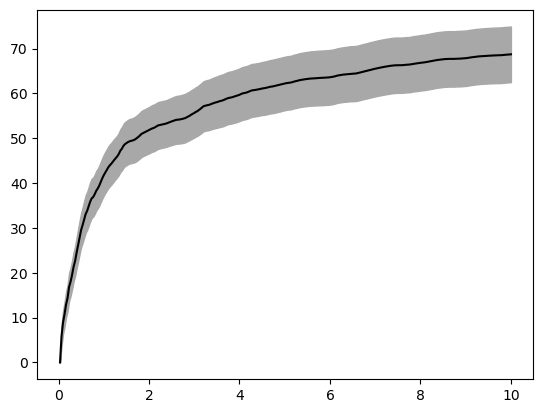

In [686]:
plot_err2(mv_vals, std_vals / np.sqrt(n_sys) / 2, x=xvals)

['Transformer' 'LSTM' 'NVAR' 'Linear' 'TiDE' 'NBEATS']
Transformer 0
-1
LSTM 10
9
NVAR 20
19
Linear 30
29
TiDE 40
39
NBEATS 50
49


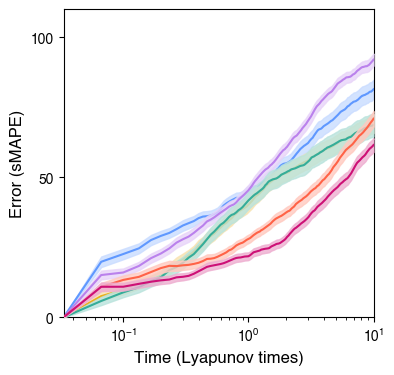

In [698]:

import degas as dg
smape_threshold = 30
all_all_vals, all_all_prediction_horizons = list(), list()
all_vals_dict, all_predictions_dict = dict(), dict()
for model_name in model_names:
    all_vals = list()
    all_horizons = list()
    for equation_name in all_traces.keys():

        try:
            ## Save traces
            vals = all_traces[equation_name][model_name]
            all_vals.append(vals)

            ## Save prediction horizon
            exceed_times = np.where(vals > smape_threshold)[0]
            if len(exceed_times) == 0:
                tind = len(vals)
            else:
                tind = exceed_times[0]
            all_horizons.append(tind)
        except:
            pass

    all_vals_dict[model_name] = np.array(all_vals)
    all_predictions_dict[model_name] = np.array(all_horizons)
    # all_all_vals.append(np.array(all_vals))
    # all_all_prediction_horizons.append(np.array(all_horizons))
# all_all_vals = np.array(all_all_vals)
# all_all_prediction_horizons = np.array(all_all_prediction_horizons)
xvals = np.arange(1, all_vals_dict[model_names[0]].shape[-1] + 1) / granularity

## Scale by granularity
all_predictions_dict = {model_name: all_predictions_dict[model_name] / granularity for model_name in all_predictions_dict}

sort_order = np.argsort([np.median(all_predictions_dict[model_name]) for model_name in all_predictions_dict])
print(model_names[sort_order])

all_colors = np.array([dg.blue, dg.lighter(dg.purple), dg.orange, dg.turquoise, dg.red, dg.magenta])#[np.argsort(sort_order)]

# import degas as dg

plt.figure(figsize=(4, 4))
for i, model_name in enumerate(model_names[sort_order]):
    print(model_name, 10*i)
    n_sys = all_vals_dict[model_names[0]].shape[0]
    # mv_vals = np.mean(all_all_vals, axis=1)[i]
    # std_vals = np.std(all_all_vals, axis=1)[i]
    mv_vals = np.mean(all_vals_dict[model_name], axis=0)
    std_vals = np.std(all_vals_dict[model_name], axis=0)
    

    # plt.plot(mv_vals, label=model_size)
    plt.semilogx()
    # dg.plot_err(mv_vals, std_vals / np.sqrt(n_sys) / 2, x=xvals, color=all_colors[i], label=model_size)
    plot_err2(mv_vals, std_vals / np.sqrt(n_sys) / 3, x=xvals, color=all_colors[i], label=model_name, zorder=10*i, fill_kwargs={"alpha": 0.8})

plt.xlabel("Time (Lyapunov times)", fontname="Helvetica", fontsize=12)
plt.ylabel("Error (sMAPE)", fontname="Helvetica", fontsize=12)
# plt.legend(fontsize=10, frameon=False, prop={'family':"Helvetica", 'size':12})
# plt.legend()
plt.xlim(np.min(xvals), np.max(xvals))
plt.ylim(0, 110)
plt.yticks([0, 50, 100])
# set font name of x-axis labels
plt.xticks(fontname="Helvetica")
plt.yticks(fontname="Helvetica")



# dg.better_savefig("./fig_resources/baseline_traces.png", dpi=300)

(array([0., 2., 4., 6.]),
 [Text(0, 0.0, '0'), Text(0, 2.0, '2'), Text(0, 4.0, '4'), Text(0, 6.0, '6')])

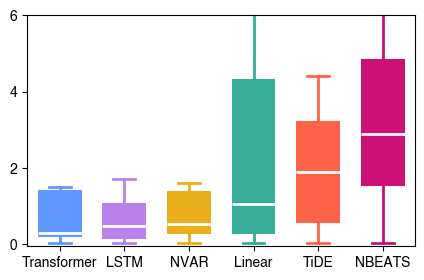

In [707]:


plt.figure(figsize=(5, 3))
plt.ylim(-0.05, 6)
## Make a boxplot of the prediction horizons
# Use all_colors to color each box differently
# Boxes are very close together, so use a different color for each box
# all_all_prediction_horizons2 = [item / granularity for item in all_all_prediction_horizons]
# all_all_prediction_horizons2 = list()
# for i in sort_order:
#     all_all_prediction_horizons2.append(all_all_prediction_horizons[i] / granularity)
    
box = plt.boxplot(
    [all_predictions_dict[model_name] for model_name in model_names[sort_order]], 
    labels=model_names[sort_order], 
    patch_artist=True, showfliers=False, 
    widths=0.34, positions=np.arange(len(model_names))/2
)

plt.xlim(-0.25, 2.75)
for patch, color in zip(box['boxes'], all_colors):
    patch.set_facecolor(color)
    patch.set_linewidth(0)
    patch.set_edgecolor(color)

for median, color in zip(box['medians'], all_colors):
    median.set_color("w")
    median.set_linewidth(2)

for i, (cap, whisker) in enumerate(zip(box['caps'], box['whiskers'])):
    color = all_colors[i // 2]
    whisker.set_color(color)
    cap.set_color(color)
    whisker.set_linewidth(2)
    cap.set_linewidth(2)

plt.yticks([0.0, 2.0, 4.0, 6.0])
plt.xticks(fontname="Helvetica")
plt.yticks(fontname="Helvetica")

# plt.xlabel("Model")
# plt.ylabel("Prediction Horizon (Lyapunov times)")
# plt.title(f"Prediction Horizon for SMAPE > {smape_threshold}")

# dg.better_savefig("./fig_resources/baselines_legend.png", dpi=300)


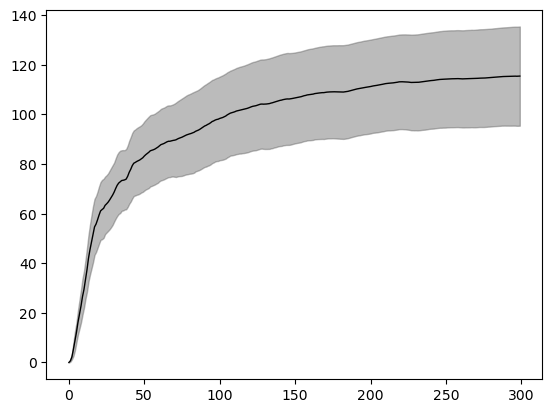

In [340]:
dg.plot_err(mv_vals, std_vals / np.sqrt(n_sys))

In [338]:
len(all_all_vals)

6

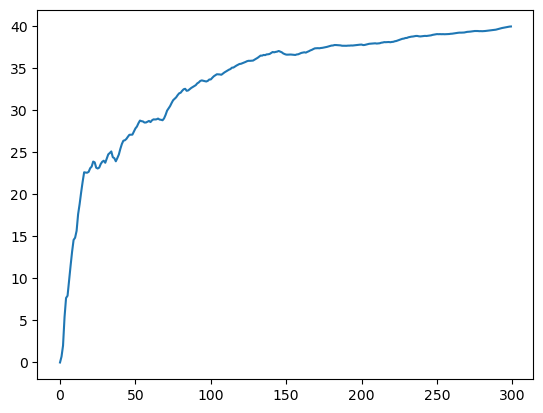

In [336]:
plt.plot(std_vals)

In [331]:
[item.shape for item in std_vals ]

[(300,), (300,), (300,), (300,), (300,), (300,)]

In [326]:
mv_vals

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]